# <center> Study Project-5: Regression

### <center> New York City Taxi Trip Duration
<center> <img src=https://storage.googleapis.com/kaggle-competitions/kaggle/3333/media/taxi_meter.png style='width:300px;'>

**Business Task**
A typical taxi company faces a common problem of efficiently assigning the cabs to passengers so that the service is smooth and hassle free. One of main issue is determining the duration of the current trip so it can predict when the cab will be free for the next trip.

The data set contains the data regarding several taxi trips and its duration in New York City. 

**Technical Task**
* Using the data to build a model that predicts the total ride duration of taxi trips in New York City.

**Type of ML task**
* Regression

**Metrics:** RMSLE (Root Mean Squared Log Error)

**Data:** The csv file contains 11 fields (10 + 1 target)

# <p style="text-align:center;font-size:100%;">0. Install and Import</p>

In [1]:
## Installing libs
#!pip install scipy #stat criterion
#!pip install xgboost

# Import libs
import numpy as np
import pandas as pd
import datetime

# Libs for visualization
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

# Normality test:
from scipy.stats import normaltest # D'Agostino's K-squared test

# ML metrics
from sklearn import metrics

# Libs for feature selection
from sklearn import feature_selection

# Models
from sklearn import linear_model
from sklearn import preprocessing
from sklearn import model_selection
from sklearn import tree
from sklearn import ensemble
from sklearn import cluster
import xgboost as xgb

import warnings
warnings.filterwarnings('ignore')

In [2]:
# Fixing RANDOM_SEED to make experiment repetable
RANDOM_SEED = 42

# Fixing package versions to make experiment repetable
!pip freeze > requirements.txt

In [3]:
# Load datasets
taxi_data = pd.read_csv('data/train.csv') # dataset for training
test_data = pd.read_csv('data/test_data.csv') # dataset for prediction

osrm_train = pd.read_csv('data/osrm_data_train.csv') # osrm for train part
osrm_test = pd.read_csv('data/osrm_data_test.csv') # osrm for test part

holiday_data = pd.read_csv('data/holiday_data.csv', sep=';') # dataset with holiday information
weather_data = pd.read_csv('data/weather_data.csv') # weather dataset

***

## <center> 1. Checking dataset: outliers, duplicates

Let's read the dataset into the DataFrame *taxi_data* and will have a look at the *shape, columns, column data types and the first 5 rows of the data*. This will give a brief overview of the data at hand.

In [4]:
# Reading csv-file
display(taxi_data.head())
display(taxi_data.info())

print(f'\nData shape: {taxi_data.shape}')

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration
0,id2875421,2,2016-03-14 17:24:55,2016-03-14 17:32:30,1,-73.982155,40.767937,-73.964630,40.765602,N,455
1,id2377394,1,2016-06-12 00:43:35,2016-06-12 00:54:38,1,-73.980415,40.738564,-73.999481,40.731152,N,663
2,id3858529,2,2016-01-19 11:35:24,2016-01-19 12:10:48,1,-73.979027,40.763939,-74.005333,40.710087,N,2124
3,id3504673,2,2016-04-06 19:32:31,2016-04-06 19:39:40,1,-74.010040,40.719971,-74.012268,40.706718,N,429
4,id2181028,2,2016-03-26 13:30:55,2016-03-26 13:38:10,1,-73.973053,40.793209,-73.972923,40.782520,N,435


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1458644 entries, 0 to 1458643
Data columns (total 11 columns):
 #   Column              Non-Null Count    Dtype  
---  ------              --------------    -----  
 0   id                  1458644 non-null  object 
 1   vendor_id           1458644 non-null  int64  
 2   pickup_datetime     1458644 non-null  object 
 3   dropoff_datetime    1458644 non-null  object 
 4   passenger_count     1458644 non-null  int64  
 5   pickup_longitude    1458644 non-null  float64
 6   pickup_latitude     1458644 non-null  float64
 7   dropoff_longitude   1458644 non-null  float64
 8   dropoff_latitude    1458644 non-null  float64
 9   store_and_fwd_flag  1458644 non-null  object 
 10  trip_duration       1458644 non-null  int64  
dtypes: float64(4), int64(3), object(4)
memory usage: 122.4+ MB


None


Data shape: (1458644, 11)


***

*This dataset contains only train part. We will use it in order to train and validate our model. Also there is the test part - we will use it for check total quality of model at the final stage of this project*

***

The dataset is dedicated to the taxi trip information and contains 1_458_644 rows and 11 columns. There are 10 features and 1 target variable which is **trip_duration**

Let`s divide all features into 4 groups:
- client`s and taxi station info
- time features
- geographic information
- other feauters

*Clients' and taxi station info:*
* id — a unique identifier for each trip;
* vendor_id — a code indicating the provider associated with the trip record.

*Time features:*
* pickup_datetime — date and time when the meter was engaged;
* dropoff_datetime — date and time when the meter was disengaged.

*Geographic Information:*
* pickup_longitude — the longitude where the meter was engaged;
* pickup_latitude — the latitude where the meter was engaged;
* dropoff_longitude — the longitude where the meter was disengaged;
* dropoff_latitude — the latitude where the meter was disengaged.

*Other Features:*
* passenger_count — the number of passengers in the vehicle (driver entered value);
* store_and_fwd_flag — This flag indicates whether the trip record was held in vehicle memory before sending to the vendor because the vehicle did not have a connection to the server - Y=store and forward; N=not a store and forward trip.

*Target Value:*
* trip_duration — duration of the trip in seconds.

We define 0 column with Missing Values (MV) and duplicates.

In [5]:
"""
Define Unique category in each column
"""
unique_list = []

for col in taxi_data.columns:
    # creating tuple: column name, number of unique values, type
    item = (col, taxi_data[col].nunique(), taxi_data[col].dtypes, taxi_data[col].unique())
    unique_list.append(item)
    
unique_counts = pd.DataFrame(
    unique_list,
    columns=['Column_Name', 'Num_Unique', 'Type', 'Unique_category']
).sort_values(by='Num_Unique', ignore_index=True)


display(unique_counts)

,Column_Name,Num_Unique,Type,Unique_category
0,vendor_id,2,int64,"[2, 1]"
1,store_and_fwd_flag,2,object,"[N, Y]"
2,passenger_count,10,int64,"[1, 6, 4, 2, 3, 5, 0, 7, 9, 8]"
3,trip_duration,7417,int64,"[455, 663, 2124, 429, 435, 443, 341, 1551, 255..."
4,pickup_longitude,23047,float64,"[-73.98215484619139, -73.98041534423827, -73.9..."
5,dropoff_longitude,33821,float64,"[-73.96463012695312, -73.99948120117188, -74.0..."
6,pickup_latitude,45245,float64,"[40.76793670654297, 40.738563537597656, 40.763..."
7,dropoff_latitude,62519,float64,"[40.765602111816406, 40.731151580810554, 40.71..."
8,pickup_datetime,1380222,object,"[2016-03-14 17:24:55, 2016-06-12 00:43:35, 201..."
9,dropoff_datetime,1380377,object,"[2016-03-14 17:32:30, 2016-06-12 00:54:38, 201..."


Some observations about the data:

* The columns id and vendor_id are nominal.
* The columns pickup_datetime and dropoff_datetime are stored as object which must be converted to datetime for better analysis.
* The column store_and_fwd_flag is categorical

In [6]:
"""
Lets look at the numerical columns
"""
round(taxi_data.describe(), 2)

,vendor_id,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,trip_duration
count,1458644.00,1458644.00,1458644.00,1458644.00,1458644.00,1458644.00,1458644.00
mean,1.53,1.66,-73.97,40.75,-73.97,40.75,959.49
std,0.50,1.31,0.07,0.03,0.07,0.04,5237.43
min,1.00,0.00,-121.93,34.36,-121.93,32.18,1.00
25%,1.00,1.00,-73.99,40.74,-73.99,40.74,397.00
50%,2.00,1.00,-73.98,40.75,-73.98,40.75,662.00
75%,2.00,2.00,-73.97,40.77,-73.96,40.77,1075.00
max,2.00,9.00,-61.34,51.88,-61.34,43.92,3526282.00


Some observations about the data:

* There are no numerical columns with missing data
* The passenger count varies between 1 and 9 with most people number of people being 1 or 2
* The trip duration varying from 1s to 3_526_282s~980 hrs. There are definitely some outliers present which must be treated.

In [7]:
"""
Lets look at the non numerical columns
"""
taxi_data.describe(include='object')

,id,pickup_datetime,dropoff_datetime,store_and_fwd_flag
count,1458644,1458644,1458644,1458644
unique,1458644,1380222,1380377,2
top,id2875421,2016-03-04 08:07:34,2016-02-19 19:25:04,N
freq,1,5,5,1450599


* There are no columns with missing values (explicit)

***

# <p style="text-align:center;font-size:100%;">2. Exploratory Data Analysis (EDA). Feature Engineering</p>

*Feature engineering is the process of transforming variables, and extracting and creating new variables from the original data points, to train machine learning models.*

***

## *Time Features*

We have 2 features with time characteristics:
* pickup_datetime
* dropoff_datetime

It's necessary convert these columns to datetime type in order to get additional information for further work.

***

### `pickup_datetime`

In [8]:
# Convert 'pickup_datetime' column to datetime type
taxi_data['pickup_datetime'] = pd.to_datetime(taxi_data['pickup_datetime'], format='%Y-%m-%d %H:%M:%S')
taxi_data['dropoff_datetime'] = pd.to_datetime(taxi_data['dropoff_datetime'], format='%Y-%m-%d %H:%M:%S')

# Check: Look at the last and first time of taxi ride
print(f'Last time (yyyy-mm-dd): {taxi_data.pickup_datetime.max()}')
print(f'First time (yyyy-mm-dd): {taxi_data.pickup_datetime.min()}')

Last time (yyyy-mm-dd): 2016-06-30 23:59:39
First time (yyyy-mm-dd): 2016-01-01 00:00:17


### `trip_duration`

In [9]:
print(f'Mean time of trip duration (in seconds): {round(taxi_data.trip_duration.mean())}')
print(f'Median time of trip duration (in seconds): {round(taxi_data.trip_duration.median())}')
print(f'Mininmum time of trip duration (in seconds): {round(taxi_data.trip_duration.min())}')
print(f'Maximum time of trip duration (in days): {round(taxi_data.trip_duration.max() / 60 / 60 / 24)}')

Mean time of trip duration (in seconds): 959
Median time of trip duration (in seconds): 662
Mininmum time of trip duration (in seconds): 1
Maximum time of trip duration (in days): 41


Base on these results I note the next points:
* There are differences between *mean* and *median* values. About 300 points.

-> It will be more correct to use *median* value/ log mean which one is more stable with outliers in dataset.

* Mininmum time of trip duration - 1 sec
* Maximum time of trip duration - more than 40 days

It`s look like outliers. We should check it at the next step.

In [10]:
"""
Function to get 3 new time feautures:
- pickup_date - date of turning on the meter / start of the trip (without time)
- pickup_hour - hour of turning on the counter
- pickup_day_of_week - day of the week on which the counter was enabled
"""
def add_datetime_features(df):
    df['pickup_date'] = df['pickup_datetime'].dt.date
    df['pickup_hour'] = df['pickup_datetime'].dt.hour
    df['pickup_day'] = df['pickup_datetime'].dt.day_name()
    
    return df


add_datetime_features(taxi_data)

# Check
print('Number of taxi trips on Saturday: ')
display(taxi_data[taxi_data['pickup_day'] == 'Saturday'].shape[0])
print('\nNumber of taxi trips per day: ')
display(taxi_data['pickup_date'].value_counts().mean())

Number of taxi trips on Saturday: 


220868


Number of taxi trips per day: 


8014.527472527472

The situation on the road depends on the day of week - weekend/ working day / holiday. A lot amount of cars create traffic jam and could be a reason of increasing trip duration by taxi.

Let`s add information about holidays.

In [11]:
"""
Dataset with american holidays in 2016
"""
display(holiday_data)

,day,date,holiday
0,Friday,2016-01-01,New Years Day
1,Monday,2016-01-18,Martin Luther King Jr. Day
2,Friday,2016-02-12,Lincoln's Birthday
3,Monday,2016-02-15,Presidents' Day
4,Sunday,2016-05-08,Mother's Day
5,Monday,2016-05-30,Memorial Day
6,Sunday,2016-06-19,Father's Day
7,Monday,2016-07-04,Independence Day
8,Monday,2016-09-05,Labor Day
9,Monday,2016-10-10,Columbus Day


This dataset contains 3 columns:
- day of week
- date
- holiday

As you can see there are 14 holidays in 2016.

In [12]:
"""
Function to add holiday features information to our dataset
"""
def add_holiday_features(df, df_holiday):
    # Convert 'date' column to datetime type
    df_holiday['date'] = pd.to_datetime(df_holiday['date'], format='%Y-%m-%d')
    df['pickup_date'] = pd.to_datetime(df['pickup_date'], format='%Y-%m-%d')
    
    # Merging of tables into one dataset
    df_merged = df.merge(df_holiday,
                         left_on='pickup_date',
                         right_on='date',
                         how='left')
    
    # Create list of holidays
    holidays = list(df_holiday['holiday'].unique())

    # Filling missing values by 0
    df_merged['pickup_holiday'] = df_merged['holiday'].apply(lambda x: 1 if x in holidays else 0)
    
    df['pickup_holiday'] = df_merged['pickup_holiday']
    
    return df


add_holiday_features(taxi_data, holiday_data)

# Check
print('Median time of trip duration in holidays: ')
display(taxi_data[taxi_data['pickup_holiday'] == 1]['trip_duration'].median())

Median time of trip duration in holidays: 


585.0

***

## *Geographic Information*

OSRM (Open Source Routing Machine) is an open-source router (compute the shortest path).
Useful information:
- id - trip id
- total distance - the shortest path (in meter) from start to end;
- number of steps - number of driver's discrete steps (turn left / turn right / go straight)
- total travel time - minimum travel time (in sec) from start to end.

*Travel time computing by OSRM is not real time, because it computes the fastest route between coordinates in ideal conditions (no traffic jam, good weather conditions and other external factors)*

But anyway it is interesting variables to look at.

***

### `OSRM data`

In [13]:
"""
Dataset with OSRM information
"""
osrm_train.head(5)

,id,starting_street,end_street,total_distance,total_travel_time,number_of_steps,street_for_each_step,distance_per_step,travel_time_per_step,step_maneuvers,step_direction,step_location_list
0,id2875421,Columbus Circle,East 65th Street,2009.1,164.9,5,Columbus Circle|Central Park West|65th Street ...,0|576.4|885.6|547.1|0,0|61.1|60.1|43.7|0,depart|rotary|turn|new name|arrive,left|straight|right|straight|arrive,"-73.982316,40.767869|-73.981997,40.767688|-73...."
1,id2377394,2nd Avenue,Washington Square West,2513.2,332.0,6,2nd Avenue|East 13th Street|5th Avenue|Washing...,877.3|836.5|496.1|164.2|139.1|0,111.7|109|69.9|25.8|15.6|0,depart|turn|turn|end of road|continue|arrive,none|right|left|right|left|arrive,"-73.980429,40.73857|-73.985444,40.731658|-73.9..."
2,id3504673,Greenwich Street,Broadway,1779.4,235.8,4,Greenwich Street|Park Place|Broadway|Broadway,644.2|379.9|755.3|0,80.5|50.8|104.5|0,depart|turn|end of road|arrive,left|left|right|arrive,"-74.010145,40.719982|-74.011527,40.714294|-74...."
3,id2181028,Broadway,West 81st Street,1614.9,140.1,5,Broadway|West 86th Street|Columbus Avenue|West...,617|427.4|412.2|158.3|0,56|36|37.8|10.3|0,depart|turn|turn|turn|arrive,right|left|right|left|arrive,"-73.972998,40.793187|-73.976607,40.788361|-73...."
4,id0801584,Lexington Avenue,West 31st Street,1393.5,189.4,5,Lexington Avenue|East 27th Street|Madison Aven...,18.9|311.9|313.3|749.4|0,6.3|42.9|48.4|91.8|0,depart|turn|turn|turn|arrive,right|right|right|left|arrive,"-73.982805,40.742173|-73.982914,40.742024|-73...."


In [14]:
"""
Function to add new columns from OSRM dataset:
- total_distance,
- total_travel_time,
- number_of_steps
"""
def add_osrm_features(df, df_osrm):
    df_osrm = df_osrm[['id', 'total_distance', 'total_travel_time', 'number_of_steps']]
    
    # Merging of datasets into one
    df = df.merge(df_osrm,
                  on='id',
                  how='left')
    
    return df


taxi_data = add_osrm_features(taxi_data, osrm_train)
print(f'Differences between median trip duration in train data and median trip dutation in OSRM: {taxi_data.trip_duration.median() - taxi_data.total_travel_time.median()}')

Differences between median trip duration in train data and median trip dutation in OSRM: 372.5


There are missing values in updated dataset after merging taxi_data with information from OSRM dataset.

Possible reason: *Failed to upload data from web source*

In [15]:
# features with missing values
nulls_data = taxi_data.isnull().sum()
nulls = nulls_data[nulls_data > 0]

print(f'\nFeatures with nulls: {nulls_data[nulls_data>0].count()}\n{nulls}')
display(nulls_data)


Features with nulls: 3
total_distance       1
total_travel_time    1
number_of_steps      1
dtype: int64


id                    0
vendor_id             0
pickup_datetime       0
dropoff_datetime      0
passenger_count       0
pickup_longitude      0
pickup_latitude       0
dropoff_longitude     0
dropoff_latitude      0
store_and_fwd_flag    0
trip_duration         0
pickup_date           0
pickup_hour           0
pickup_day            0
pickup_holiday        0
total_distance        1
total_travel_time     1
number_of_steps       1
dtype: int64

### `Haversine distance`

Let's add new features to compute distance between start and end point of trip by haversine formula.

This formula calculates the shortest distance between two points on a sphere using their latitudes and longitudes measured along the surface.

In [16]:
"""
Function to compute haversine formula (distance in km) - h
"""
def get_haversine_distance(lat1, lng1, lat2, lng2):
    # convert angle measure to radians
    lat1, lng1, lat2, lng2 = map(np.radians, (lat1, lng1, lat2, lng2))
    
    # Earth radius in km
    EARTH_RADIUS = 6371
    
    # calculate the shortest distance (h) by haversine formula
    lat_delta = lat2 - lat1
    lng_delta = lng2 - lng1
    d = np.sin(lat_delta*0.5) ** 2 + np.cos(lat1) * np.cos(lat2) * np.sin(lng_delta*0.5) ** 2
    h = 2 * EARTH_RADIUS * np.arcsin(np.sqrt(d))
    
    return h


"""
Function to compute angle direction (radian) - alpha
"""
def get_angle_direction(lat1, lng1, lat2, lng2):
    # convert angle measure to radians
    lat1, lng1, lat2, lng2 = map(np.radians, (lat1, lng1, lat2, lng2))
    
    # calculate the angles from the bearings
    lng_delta_rad = lng2 - lng1
    y = np.sin(lng_delta_rad) * np.cos(lat2)
    x = np.cos(lat1) * np.sin(lat2) - np.sin(lat1) * np.cos(lat2) * np.cos(lng_delta_rad)
    alpha = np.degrees(np.arctan2(y, x))
    
    return alpha

"""
Function to update our dataset by new geographic features:
- haversine_distance
- direction
"""
def add_geographical_features(df):
    df['haversine_distance'] = get_haversine_distance(df['pickup_latitude'], df['pickup_longitude'], df['dropoff_latitude'], df['dropoff_longitude'])
    df['direction'] = get_angle_direction(df['pickup_latitude'], df['pickup_longitude'], df['dropoff_latitude'], df['dropoff_longitude'])
    
    return df


taxi_data = add_geographical_features(taxi_data)

print('Median value of haversine distance: ')
display(round(taxi_data['haversine_distance'].median(), 2))

Median value of haversine distance: 


2.09

### `Clusters by geographic coordinate`

Now let's try to get clusters from geographic coordinations.

Key idea:
- grouped all taxi trips by start and end coordinates using clusterization methods in order to get information about district of trips.

Hypothesis:
- time of trip duration depends on the geographical clusters.

*Clusterization method: K-Means*

In [17]:
"""
Clusterization method: K-Means
Number of clusters: 10
Data: latitude and longitude coordinates
"""
# Create trainig set from geographical coordinates
coords = np.hstack((taxi_data[['pickup_latitude', 'pickup_longitude']],
                    taxi_data[['dropoff_latitude', 'dropoff_longitude']]))

# Training clusterization algorithm
kmeans_geo = cluster.KMeans(n_clusters=10, n_init=10, random_state=RANDOM_SEED).fit(coords)

"""
Function to add clusters information to our key dataset (taxi_data)
"""
def add_cluster_features(df, kmeans_geo):
    coords = np.hstack((df[['pickup_latitude', 'pickup_longitude']],
                        df[['dropoff_latitude', 'dropoff_longitude']]))
    
    df['geo_cluster'] = kmeans_geo.predict(coords)
    
    return df


taxi_data = add_cluster_features(taxi_data, kmeans_geo)

print('Number of taxi trips by 10 clusters: ')
display(taxi_data['geo_cluster'].value_counts())

Number of taxi trips by 10 clusters: 


0    596467
9    383874
4    359233
5     43619
7     41171
3     27022
1      7233
6        18
8         5
2         2
Name: geo_cluster, dtype: int64

### `weather data`

The other meaningful factor is **weather**. Snowy or rainy weather could be the reason of trip time increasing.

Let's use additional dataset with information about weather conditions in New York in 2016

In [18]:
"""
Dataset with weather condition information
"""
weather_data.head()

,time,temperature,windchill,heat index,humidity,pressure,dew Point,visibility,wind dir,wind speed,gust speed,precip,events,conditions,date,hour
0,2015-12-31 02:00:00,7.8,7.1,NaN,0.89,1017.0,6.1,8.0,NNE,5.6,0.0,0.8,None,Overcast,2015-12-31,2
1,2015-12-31 03:00:00,7.2,5.9,NaN,0.90,1016.5,5.6,12.9,Variable,7.4,0.0,0.3,None,Overcast,2015-12-31,3
2,2015-12-31 04:00:00,7.2,NaN,NaN,0.90,1016.7,5.6,12.9,Calm,0.0,0.0,0.0,None,Overcast,2015-12-31,4
3,2015-12-31 05:00:00,7.2,5.9,NaN,0.86,1015.9,5.0,14.5,NW,7.4,0.0,0.0,None,Overcast,2015-12-31,5
4,2015-12-31 06:00:00,7.2,6.4,NaN,0.90,1016.2,5.6,11.3,West,5.6,0.0,0.0,None,Overcast,2015-12-31,6


Columns with useful information:

* time — measure time (in hour),
* temperature,
* visibility,
* wind speed — wind average speed,
* precip — rainfall,
* events — weather conditions:
    - Rain,
    - Snow,
    - Fog,
    - None — no weather events.

In [19]:
"""
Function to add features about weather conditions:
- temperature,
- visibility,
- wind speed,
- precip,
- events
"""
def add_weather_features(df, weather):
    # Converting 'date' column to datetime type
    weather['pickup_date'] = pd.to_datetime(weather['time']).dt.date
    weather['pickup_hour'] = pd.to_datetime(weather['time']).dt.hour
    
    df['pickup_date'] = pd.to_datetime(df['pickup_date']).dt.date
    
    weather = weather[['pickup_date', 'pickup_hour', 'temperature', 'visibility',
                'wind speed', 'precip', 'events']]
    
    # Merging of tables into one dataset
    df_merged = df.merge(weather,
                         on=['pickup_date', 'pickup_hour'],
                         how='left')
    
    return df_merged


taxi_data = add_weather_features(taxi_data, weather_data)

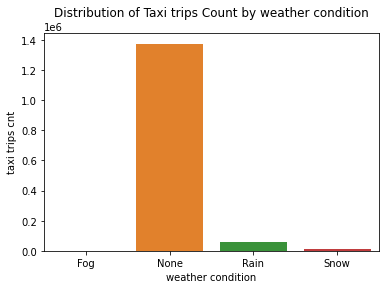

In [20]:
trip_weather = taxi_data.groupby(['events'])['id'].count().reset_index()
trip_weather.columns = ['weather condition', 'taxi trips cnt']

# Distribution of taxi trips cnt by weather conditions
sns.barplot(x='weather condition', y='taxi trips cnt', data=trip_weather)
plt.title('Distribution of Taxi trips Count by weather condition')
plt.show()

There are missing values in updated dataset after merging taxi_data with information from weather conditions dataset.

Possible reason: *there are no measurements for some points (dataset with weather conditions info) in time at which the trip counter was turned on*

Let's check these rows with MV.

In [21]:
# Check
nulls_percentage = (taxi_data[['temperature', 'visibility', 'wind speed', 'precip', 'events']].isnull().sum().sum() \
    / taxi_data[['temperature', 'visibility', 'wind speed', 'precip', 'events']].size) * 100

print('Percentage of missing values in weather conditions\' columns: ')
display(round(nulls_percentage, 2))

Percentage of missing values in weather conditions' columns: 


0.82

***

### Filling missing values & Cleaning dataset

The next step after data extension is cleaning our dataset. First of all - filling missing values by median or None values.

In [22]:
"""
Function to fill missing values
"""
def fill_null_weather_data(df):
    df['temperature'] = df['temperature'].fillna(df.groupby('pickup_date')['temperature'].transform('median'))
    df['visibility'] = df['visibility'].fillna(df.groupby('pickup_date')['visibility'].transform('median'))
    df['wind speed'] = df['wind speed'].fillna(df.groupby('pickup_date')['wind speed'].transform('median'))
    df['precip'] = df['precip'].fillna(df.groupby('pickup_date')['precip'].transform('median'))
    df['events'] = df['events'].fillna('None')
    df['total_distance'] = df['total_distance'].fillna(df['total_distance'].median())
    df['total_travel_time'] = df['total_travel_time'].fillna(df['total_travel_time'].median())
    df['number_of_steps'] = df['number_of_steps'].fillna(df['number_of_steps'].median())
    
    return df


taxi_data = fill_null_weather_data(taxi_data)

# Check
print('Temperature median value is ')
display(taxi_data['temperature'].median())

Temperature median value is 


11.1

### `Check outliers`

The last step of point *2.EDA. Feature Engineering* is checking outliers in trip_duration features:

- the longest trips - more than 24 hours,
- the shortest trips: define outliers based on trip duration + information about average speed.

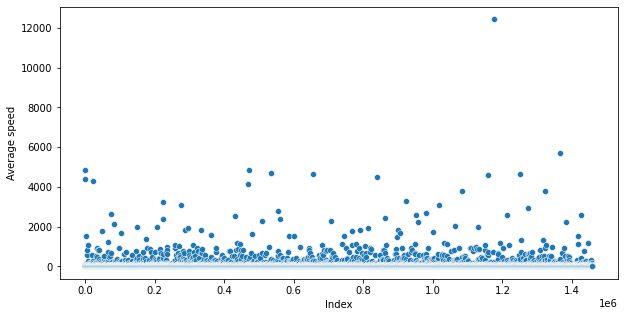

In [23]:
"""
Scatter plot: average taxi driver's speed
"""
avg_speed = taxi_data['total_distance'] / taxi_data['trip_duration'] * 3.6

fig, ax = plt.subplots(figsize=(10, 5))
sns.scatterplot(x=avg_speed.index, y=avg_speed, ax=ax)
ax.set_xlabel('Index')
ax.set_ylabel('Average speed');

As you can see, "teleportaion"-trip has average speed equals more than 1000 km/hour. There is trip with more than 12_000 km/hour!

Based on this information adequate avearge speed could be equal to 300 km/hour.

In [24]:
"""
Check and delete the next outliers:
- rows with trip duration more than 24 hours (86_400 sec)
- rows with average speed more than 300 km/hour
"""
outliers_hour = taxi_data[taxi_data['trip_duration'] > 86_400]
print(f'Number of trips with more than 24 hours Trip duration: {outliers_hour.shape[0]}')

outliers_speed = taxi_data[taxi_data['total_distance'] / taxi_data['trip_duration'] * 3.6 > 300]
print(f'Number of trips with more than 300 km/h avg speed: {outliers_speed.shape[0]}')

Number of trips with more than 24 hours Trip duration: 4
Number of trips with more than 300 km/h avg speed: 407


In [25]:
# Delete rows with outliers
taxi_data = taxi_data.drop(outliers_hour.index, axis = 0)
taxi_data = taxi_data.drop(outliers_speed.index, axis = 0)

***

## Data Visualisation

Objectives:
- investigation dataset by using statistical graphics and other data visualization methods,
- discover trends, patterns in data.

Key metric of model is RMSLE (Root Mean Squared Log Error).

This metric is calculated by applying log to the predicted value (target) and then taking their differences.

*RMSLE is robust to outliers where the small and the large errors are treated evenly.*

In [26]:
"""
Take the logarithm of the target value
"""
taxi_data['trip_duration_log'] = np.log(taxi_data['trip_duration'] + 1)

***

Look at the distribution of various variables in the Dataset

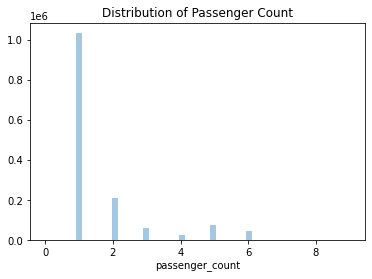

In [27]:
# Distribution of passenger_count
sns.distplot(taxi_data['passenger_count'], kde=False)
plt.title('Distribution of Passenger Count')
plt.show()

* The mostly number of passengers are 1 or 2. Large group of people travelling together is rare.

Text(0.5, 1.0, 'Number of Pickups done on each day of the week')

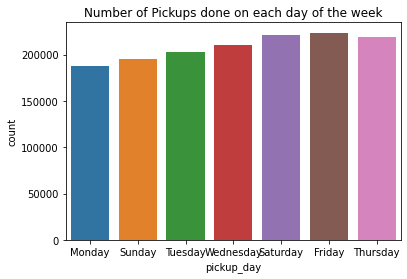

In [28]:
"""
The distribution of Pickup day of the week
"""
sns.countplot(x='pickup_day', data=taxi_data)
plt.title('Number of Pickups done on each day of the week')

* Thus we see most trips were taken on Friday and Monday being the least.

Text(0.5, 1.0, 'Distribution of pickup hours')

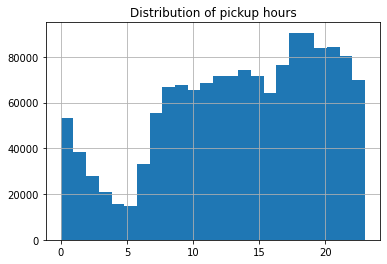

In [29]:
"""
Distribution of pickup hours
"""
taxi_data.pickup_hour.hist(bins=24)
plt.title('Distribution of pickup hours')

The time part is represented by hours, minutes and seconds which is difficult for the analysis. Thus divide the times into 4 time zones:
* morning (5 hrs to 12 hrs)
* midday (12 hrs to 18 hrs)
* evening (18 hrs to 21 hrs)
* night (21 hrs to 5 hrs)

In [30]:
def timezone(x):
    if x >= datetime.time(5, 0, 1) and x <= datetime.time(12, 0, 0):
        return 'morning'
    elif x >= datetime.time(12, 0, 1) and x <= datetime.time(17, 0, 0):
        return 'midday'
    elif x >= datetime.time(17, 0, 1) and x <= datetime.time(21, 0, 0):
        return 'evening'
    elif x >= datetime.time(21, 0, 1) or x <= datetime.time(5, 0, 0):
        return 'night'


taxi_data['pickup_timezone'] = taxi_data['pickup_datetime'].apply(lambda x: timezone(datetime.datetime.strptime(str(x), '%Y-%m-%d %H:%M:%S').time()))

Text(0.5, 1.0, 'The distribution of number of pickups on each part of the day')

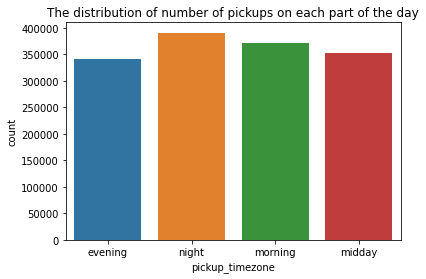

In [31]:
"""
The distribution of Pickup hours of the day
"""
sns.countplot(x='pickup_timezone', data=taxi_data)
plt.title('The distribution of number of pickups on each part of the day')

* Most pickups and drops occur **at night**. While the least drops and pickups occur during **evening**.

It's interesting situation. Because I included the time from 5 pm to 9 pm into "evening" timezone. It's time when people usually stop work and come back at home. And I suggested that this period will be more popular for taxi trips than the other. But it's not true.

Statistics=138350.166, p-value=0.000

NOT normal distribution: The data aren't normally distributed


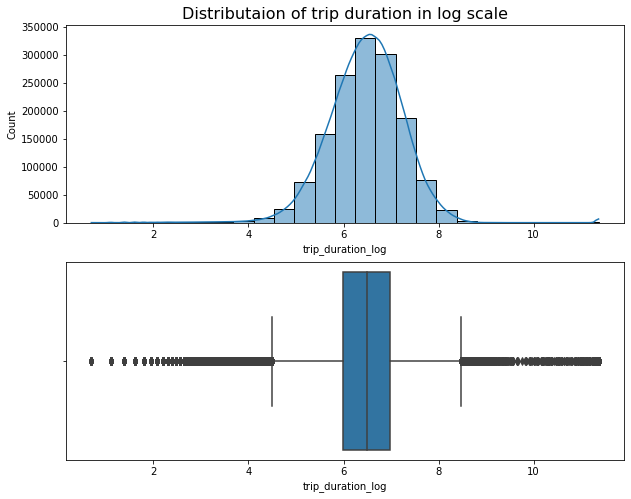

In [32]:
"""
Checking the distribution character of trip_duration feature in log scale

Statistic test to check character of distribution (ab-/normal):
- D'Agostino and Pearson normality test
- alpha = 0.05
"""
# Data visualisation: histogram and boxplot
fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(10, 8))

histplot = sns.histplot(
    data=taxi_data,
    x='trip_duration_log',
    bins=25,
    kde=True,
    ax=axes[0]);
histplot.set_title('Distributaion of trip duration in log scale',  fontsize=16);

boxplot = sns.boxplot(
    data=taxi_data,
    x='trip_duration_log',
    orient='h',
    width=0.9,
    ax=axes[1]);

# Normality test: D'Agostino and Pearson
# Define hypothesis
H0 = 'Normal distribution: Data is symmetrically distributed with no skew'
Ha = "NOT normal distribution: The data aren't normally distributed"

# p-value
alpha = 0.05

stat, p = normaltest(taxi_data['trip_duration_log'])
print('Statistics=%.3f, p-value=%.3f' % (stat, p))

# Interpretation
if p > alpha:
	print(f'\n{H0}')
else:
	print(f'\n{Ha}')

* P-value: 0.00
* The data aren't normally distributed. There are outliers.

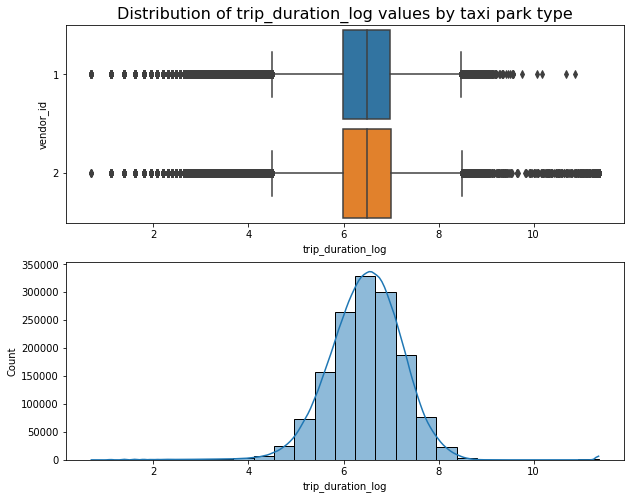

In [33]:
"""
Distribution of trip duration feature (in log scale) by taxi park type (vendor_id)
"""
# Data visualisation: histogram and boxplot
fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(10, 8))

boxplot = sns.boxplot(
    data=taxi_data,
    x='trip_duration_log',
    y='vendor_id',
    orient='h',
    width=0.9,
    ax=axes[0]
    );
boxplot.set_title('Distribution of trip_duration_log values by taxi park type',  fontsize=16);

histplot = sns.histplot(
    data=taxi_data,
    x='trip_duration_log',
    bins=25,
    kde=True,
    ax=axes[1]);

Distribution in groups are the same. It means that vendor_id feature is a weak feature to predict trip duration. And I can delete this feature at the stage of Feature Selection for build prediction model.

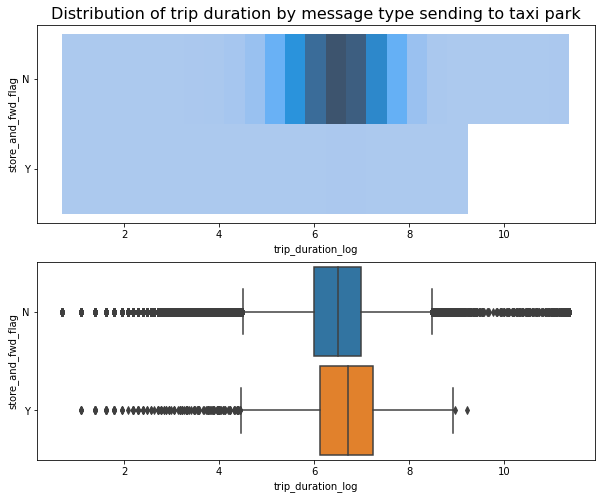

In [34]:
"""
Distribution of trip duration feature (in log scale) by message type sending to taxi park (store_and_fwd_flag)
"""
# Data visualisation: histogram and boxplot
fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(10, 8))
histplot = sns.histplot(
    data=taxi_data,
    x='trip_duration_log',
    y='store_and_fwd_flag',
    bins=25,
    kde=True,
    ax=axes[0]
);
axes[0].set_title('Distribution of trip duration by message type sending to taxi park', fontsize=16)

boxplot = sns.boxplot(
    data=taxi_data,
    x='trip_duration_log',
    y='store_and_fwd_flag',
    orient='h',
    width=0.9,
    ax=axes[1]
);

Distribution in groups are different. It means that store_and_fwd_flag feature is meaningful feature to predict trip duration time.

* the longest trip belogs to group with N message type (not a store and forward trip).

Flag is saved only for short trips, and not save for anomalous multi-hour.

Text(0.5, 1.0, 'Median trip duration time by hour of the day')

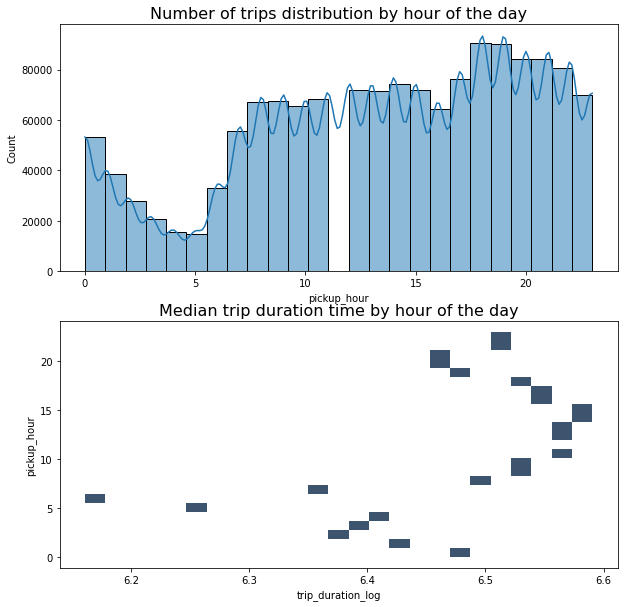

In [35]:
"""
- Number of trips distribution by hour of the day
- Median trip duration time by hour of the day
"""
# Grouped data by hour of the day value
data_hour_median = taxi_data.groupby(['pickup_hour']).median()

# Data visualisation: histograms
fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(10, 10))

histplot = sns.histplot(
    data=taxi_data,
    x='pickup_hour',
    bins=25,
    kde=True,
    ax=axes[0]
);
axes[0].set_title('Number of trips distribution by hour of the day', fontsize=16)

histplot = sns.histplot(
    data=data_hour_median,
    x='trip_duration_log',
    y='pickup_hour',
    bins=25,
    kde=True,
    ax=axes[1]
);
axes[1].set_title('Median trip duration time by hour of the day', fontsize=16)

* Taxis are ordered the least from 00:00 to 5:00
* The peak trip duration time is from 13:00 to 18:00

Text(0.5, 1.0, 'Median trip duration time by day of week')

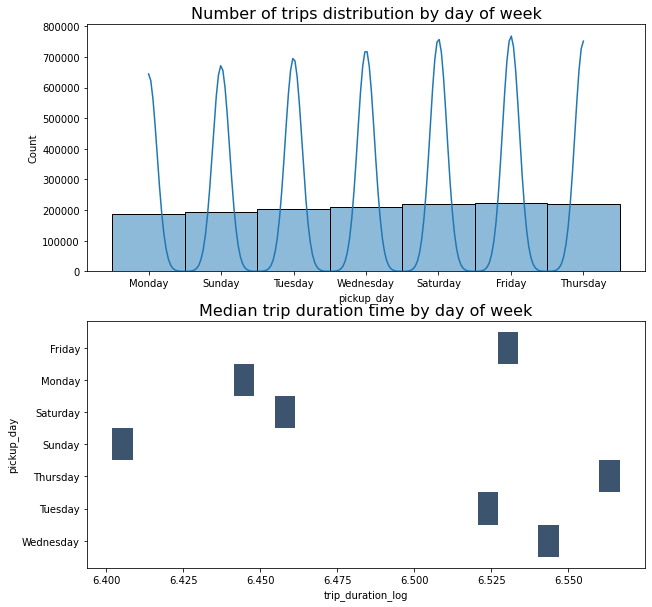

In [36]:
"""
- Number of trips distribution by day of week
- Median trip duration time by day of week
"""
# Grouped data by day of week
data_day_of_week_median = taxi_data.groupby(['pickup_day']).median()

# Data visualisation: histograms
fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(10, 10))

histplot = sns.histplot(
    data=taxi_data,
    x='pickup_day',
    bins=25,
    kde=True,
    ax=axes[0]
);
axes[0].set_title('Number of trips distribution by day of week', fontsize=16)

histplot = sns.histplot(
    data=data_day_of_week_median,
    x='trip_duration_log',
    y='pickup_day',
    bins=25,
    kde=True,
    ax=axes[1]
);
axes[1].set_title('Median trip duration time by day of week', fontsize=16)

* By checking the trip count by day of the week data, we can find that Friday is always the top busiest day of the week.
* The highest mediam time taken to complete a trip is on Thursday while Monday, Sunday takes the least time.

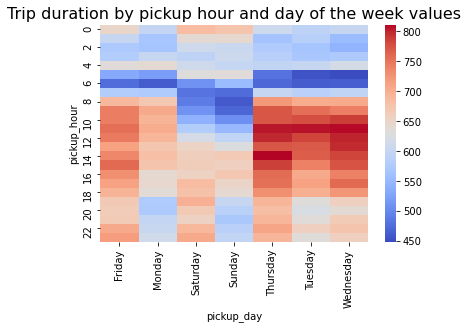

In [37]:
"""
Let's look at the two time features: pickup hour and day of the week
Building pivot table:
- row - pickup_hour
- column - day of the week
- values - trip duration
"""
# pivot table
pivot = taxi_data.pivot_table(values='trip_duration',
                              index='pickup_hour',
                              columns='pickup_day',
                              aggfunc='median',
                              fill_value=0)

# Graph building (Seaborn) - Heatmap
heatmap = sns.heatmap(
    data=pivot,
    cmap='coolwarm'
)

heatmap.set_title('Trip duration by pickup hour and day of the week values', fontsize=16);

* The highest average time taken to complete a trip are for trips from Monday to Friday between from 8 to 18 hours
* The most average time taken to complete a trip was on Thursday at 2 p.m.

Text(0.5, 1.0, 'Geographical location of ending coordinates')

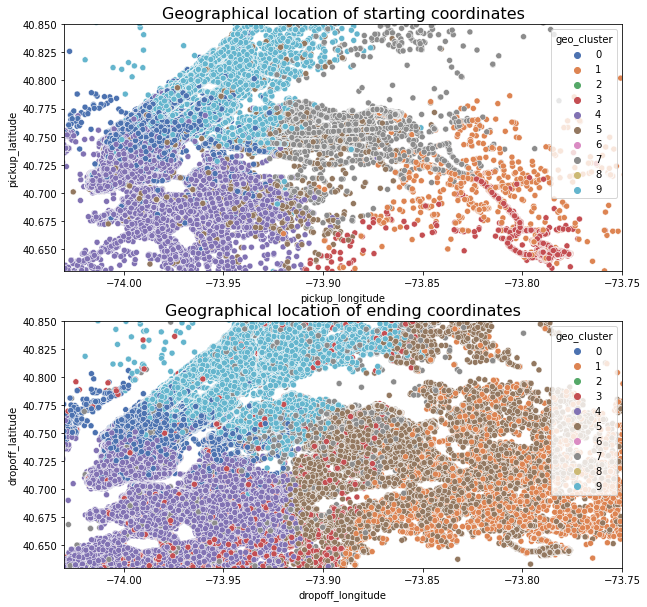

In [38]:
"""
The relationship between geographical location and duration
- geographical location of starting coordinates
- geographical location of ending coordinates
"""
# Border: New York zone
city_long_border = (-74.03, -73.75)
city_lat_border = (40.63, 40.85)

# Graph building (Plotly) - scatter plot
fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(10, 10))
scaterplot = sns.scatterplot(
    data=taxi_data,
    x='pickup_longitude',
    y='pickup_latitude',
    hue='geo_cluster', 
    ax=axes[0],
    palette='deep'
);
axes[0].set_xlim(-74.03, -73.75)
axes[0].set_ylim(40.63, 40.85)
axes[0].set_title('Geographical location of starting coordinates', fontsize=16)

scaterplot = sns.scatterplot(
    data=taxi_data,
    x='dropoff_longitude',
    y='dropoff_latitude',
    hue='geo_cluster',
    palette='deep',
    ax=axes[1]
);
axes[1].set_xlim(-74.03, -73.75)
axes[1].set_ylim(40.63, 40.85)
axes[1].set_title('Geographical location of ending coordinates', fontsize=16)

Clusters 2 and 8 are absent on the map.

***

# <p style="text-align:center;font-size:100%;">4. Feature Selection</p>

Objectives:
- coding categorical features
- feature selection to build prediction model
- normalize features

In [39]:
# Let's look at the dataset shape and columns in updated dataset
print('Shape of data: {}'.format(taxi_data.shape))
print('Columns: {}'.format(taxi_data.columns))

Shape of data: (1458233, 28)
Columns: Index(['id', 'vendor_id', 'pickup_datetime', 'dropoff_datetime',
       'passenger_count', 'pickup_longitude', 'pickup_latitude',
       'dropoff_longitude', 'dropoff_latitude', 'store_and_fwd_flag',
       'trip_duration', 'pickup_date', 'pickup_hour', 'pickup_day',
       'pickup_holiday', 'total_distance', 'total_travel_time',
       'number_of_steps', 'haversine_distance', 'direction', 'geo_cluster',
       'temperature', 'visibility', 'wind speed', 'precip', 'events',
       'trip_duration_log', 'pickup_timezone'],
      dtype='object')


***

In [40]:
"""
Make a copy of the given DataFrame in order to protect original DF
"""
train_data = taxi_data.copy()
train_data.head()

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,...,haversine_distance,direction,geo_cluster,temperature,visibility,wind speed,precip,events,trip_duration_log,pickup_timezone
0,id2875421,2,2016-03-14 17:24:55,2016-03-14 17:32:30,1,-73.982155,40.767937,-73.964630,40.765602,N,...,1.498521,99.970196,9,4.4,8.0,27.8,0.3,None,6.122493,evening
1,id2377394,1,2016-06-12 00:43:35,2016-06-12 00:54:38,1,-73.980415,40.738564,-73.999481,40.731152,N,...,1.805507,-117.153768,4,28.9,16.1,7.4,0.0,None,6.498282,night
2,id3858529,2,2016-01-19 11:35:24,2016-01-19 12:10:48,1,-73.979027,40.763939,-74.005333,40.710087,N,...,6.385098,-159.680165,4,-6.7,16.1,24.1,0.0,None,7.661527,morning
3,id3504673,2,2016-04-06 19:32:31,2016-04-06 19:39:40,1,-74.010040,40.719971,-74.012268,40.706718,N,...,1.485498,-172.737700,4,7.2,16.1,25.9,0.0,None,6.063785,evening
4,id2181028,2,2016-03-26 13:30:55,2016-03-26 13:38:10,1,-73.973053,40.793209,-73.972923,40.782520,N,...,1.188588,179.473585,9,9.4,16.1,9.3,0.0,None,6.077642,midday


Non-informative features:
- **"id"** - a unique identifier for each trip. This feature has not any meaningful information to predict trip duration,
- **"dropoff_datetime"** - date and time when the meter was disengaged. This type of information is not available for us in future because our task is to predict trip duration (time of trip ending). If we use this feature in further to build prediction model, it creates a problem as data leakage.

In [41]:
# Delete id and dropoff_datetime features
train_data = train_data.drop(columns=['id', 'dropoff_datetime'], axis=1)
train_data.shape

(1458233, 26)

All necessary information from the next features - pickup_datetime, pickup_date - is exctracted on the previous stage.

Let's delete columns duplicated information.

In [42]:
drop_columns = ['pickup_datetime', 'pickup_date']
train_data = train_data.drop(drop_columns, axis=1)

print('Shape of data: {}'.format(train_data.shape))

Shape of data: (1458233, 24)


Encoding of categorical values:

* vendor_id,
* store_and_fwd_flag,
* pickup_day,
* geo_cluster,
* events,
* pickup_timezones

**vendor_id** and **store_and_fwd_flag** are binary values.

In [43]:
"""
Encoding binary features: vendor_id and store_and_fwd_flag
"""
train_data['vendor_id'] = train_data['vendor_id'].apply(lambda x: 0 if x == 1 else 1)
train_data['store_and_fwd_flag'] = train_data['store_and_fwd_flag'].apply(lambda x: 0 if x == 'N' else 1)

# Check
print(f'Mean value by vendor_id column: {round(train_data.vendor_id.mean(), 2)}')
print(f'Mean value by store_and_fwd_flag column: {round(train_data.store_and_fwd_flag.mean(), 3)}')

Mean value by vendor_id column: 0.53
Mean value by store_and_fwd_flag column: 0.006


In [44]:
"""
One-Hot Encoding for nominal features:
- pickup_day_of_week,
- geo_cluster,
- events
"""
train_data = pd.get_dummies(train_data, columns=['pickup_day', 'geo_cluster', 'events', 'pickup_timezone'])
train_data.head()

# Alternative way
# import category_encoders as ce
# encoder = ce.OneHotEncoder(cols=['pickup_day_of_week', 'geo_cluster', 'events'])
# data_onehot = encoder.fit_transform(train_data, drop = 'first')

# data_onehot.head()

,vendor_id,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration,pickup_hour,pickup_holiday,...,geo_cluster_8,geo_cluster_9,events_Fog,events_None,events_Rain,events_Snow,pickup_timezone_evening,pickup_timezone_midday,pickup_timezone_morning,pickup_timezone_night
0,1,1,-73.982155,40.767937,-73.964630,40.765602,0,455,17,0,...,0,1,0,1,0,0,1,0,0,0
1,0,1,-73.980415,40.738564,-73.999481,40.731152,0,663,0,0,...,0,0,0,1,0,0,0,0,0,1
2,1,1,-73.979027,40.763939,-74.005333,40.710087,0,2124,11,0,...,0,0,0,1,0,0,0,0,1,0
3,1,1,-74.010040,40.719971,-74.012268,40.706718,0,429,19,0,...,0,0,0,1,0,0,1,0,0,0
4,1,1,-73.973053,40.793209,-73.972923,40.782520,0,435,13,0,...,0,1,0,1,0,0,0,1,0,0


<AxesSubplot: >

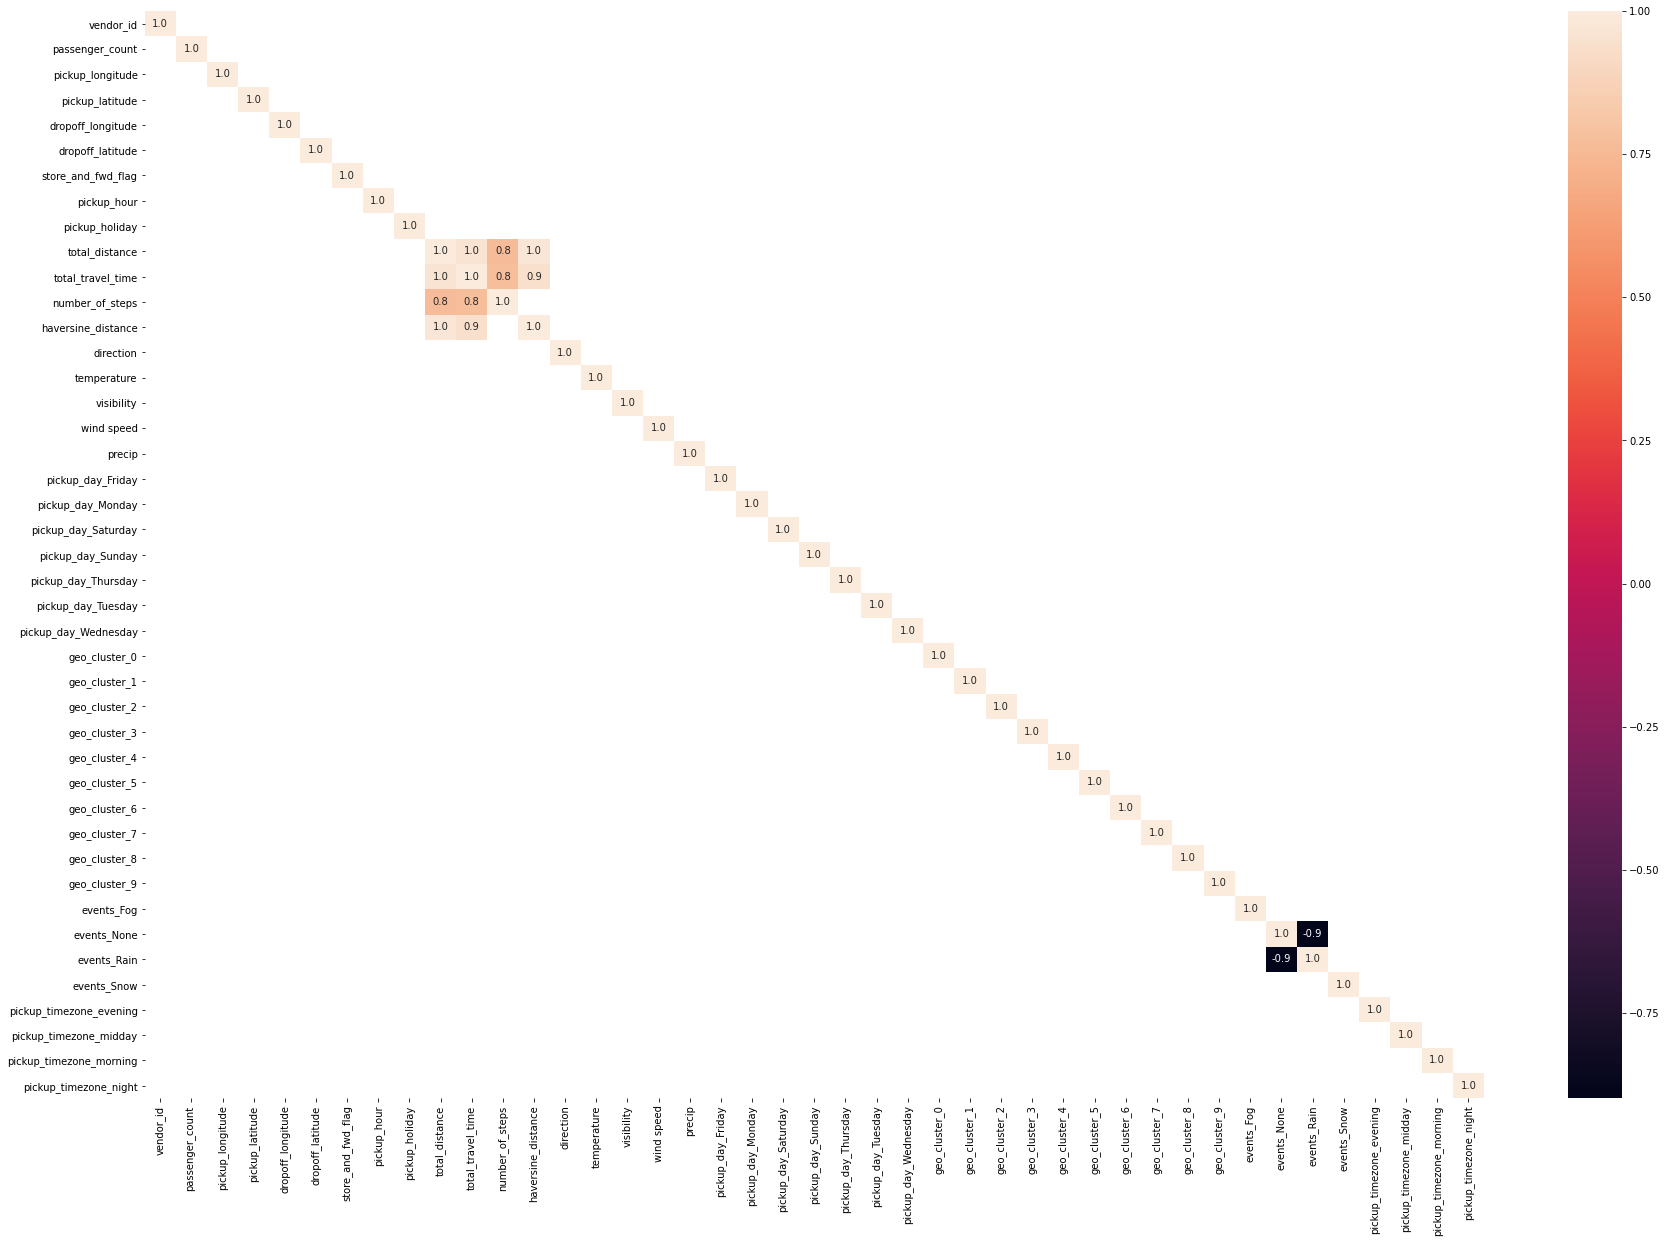

In [45]:
# creating correlation heatmap by using spearman method 
corr_data = train_data.drop(['trip_duration', 'trip_duration_log'], axis=1).corr(method='spearman')

plt.rcParams['figure.figsize'] = (30,20)

sns.heatmap(corr_data[corr_data.abs() > 0.7], annot = True,  fmt='.1f')

There is strong correlation between the next variables:

* total_distance
* total_travel_time
* number_of_steps
* haversine_distance

***

In [46]:
X = train_data.drop(['trip_duration', 'trip_duration_log', 'total_distance'], axis=1)
y = train_data['trip_duration']

y_log = train_data['trip_duration_log']

### **All models will be trained on y_log as target**

Validation type:
- hold-out validation

Our dataset consists of about 1.5 mln records. Is not a small dataset. If we use k-fold or leave-one-out-validation it needs more time.

In [47]:
# dividing for train and validation data (67/33) - hold-out validation
X_train, X_valid, y_train_log, y_valid_log = model_selection.train_test_split(X, y_log, test_size=0.33, random_state=RANDOM_SEED)

print(X_train.shape, y_train_log.shape, X_valid.shape, y_valid_log.shape)

(977016, 42) (977016,) (481217, 42) (481217,)


*Note: test data is the other dataset that will be used only for checking model's quality.*

In [48]:
"""
Reduction number of features in order to decrease time to train model and increase model's quality (if features are high correlated)

Let`s check more meaningful features using SelectKBest (25)
"""
selector = feature_selection.SelectKBest(score_func = feature_selection.f_regression, k=25)
selector.fit(X_train, y_train_log)
 
best_features = selector.get_feature_names_out()

X_train = X_train[best_features]
X_valid = X_valid[best_features]

In [49]:
print('The best 25 features:\n')
for el in range(len(best_features)):
    print(f'* {best_features[el]}')

The best 25 features:

* vendor_id
* passenger_count
* pickup_longitude
* pickup_latitude
* dropoff_longitude
* dropoff_latitude
* pickup_hour
* pickup_holiday
* total_travel_time
* number_of_steps
* haversine_distance
* temperature
* pickup_day_Monday
* pickup_day_Saturday
* pickup_day_Sunday
* pickup_day_Thursday
* pickup_day_Wednesday
* geo_cluster_0
* geo_cluster_3
* geo_cluster_5
* geo_cluster_7
* geo_cluster_9
* pickup_timezone_midday
* pickup_timezone_morning
* pickup_timezone_night


In [50]:
# Data Normalization: minmaxsxaler
mm_scaler = preprocessing.MinMaxScaler()

mm_scaler.fit(X_train)

X_train_scaled = mm_scaler.transform(X_train)
X_val_scaled = mm_scaler.transform(X_valid) 

# Check
print(f'Mean value of the first X_val predictor: {round(X_val_scaled[:, 0].mean(), 2)}')

Mean value of the first X_val predictor: 0.54


***

# <p style="text-align:center;font-size:100%;">5. Decision of regression task: Linear regression & Decision tree </p>

In [51]:
# Model
lr_model = linear_model.LinearRegression()

# Training model: target -> logloss minimization
linear_reg = lr_model.fit(X_train_scaled, y_train_log)

# Get prediction
y_train_log_pred = linear_reg.predict(X_train_scaled)
y_valid_log_pred = linear_reg.predict(X_val_scaled)

# RMSLE computing
print('RMSLE score for train data: {:.3f}'.format(np.sqrt(metrics.mean_squared_error(y_train_log, y_train_log_pred))))
print('RMSLE score for valid data: {:.3f}'.format(np.sqrt(metrics.mean_squared_error(y_valid_log, y_valid_log_pred))))

RMSLE score for train data: 0.525
RMSLE score for valid data: 0.528


In [52]:
# Creating a polynomial feature generator
poly = preprocessing.PolynomialFeatures(degree=2, include_bias=False)

poly.fit(X_train_scaled)

# Generate polynomial features for train set
X_train_poly = poly.transform(X_train_scaled)

# Generate polynomial features for valid set
X_valid_poly = poly.transform(X_val_scaled)

# Final shape of train and valid sets
print(f'Shape of train data with polynomial features: {X_train_poly.shape}')
print(f'\nShape of valid data with polynomial features: {X_valid_poly.shape}')

Shape of train data with polynomial features: (977016, 350)

Shape of valid data with polynomial features: (481217, 350)


In [53]:
# Model with Polynomial Features
lr_model_poly = linear_model.LinearRegression()

# Training model
model_poly = lr_model_poly.fit(X_train_poly, y_train_log)

# Get prediction
y_train_poly = model_poly.predict(X_train_poly)
y_valid_poly = model_poly.predict(X_valid_poly)

# RMSLE computing
print('RMSLE score for train data with Polynomial Features: {:.3f}'.format(np.sqrt(metrics.mean_squared_error(y_train_log, y_train_poly))))
print('RMSLE score for valid data with Polynomial Features: {:.3f}'.format(np.sqrt(metrics.mean_squared_error(y_valid_log, y_valid_poly))))

RMSLE score for train data with Polynomial Features: 0.453
RMSLE score for valid data with Polynomial Features: 0.534


The difference between metric values for train and valid sets means there is overfitting problem:

* Model shows better result for train set than for valid

We can use regularisation methods in order to decrease model overfitting.

In [54]:
# Linear model with L2-regularisation
ridge_lr_poly = linear_model.Ridge(alpha=1)

# Model training
ridge_lr_poly.fit(X_train_poly, y_train_log)

# Get prediction
y_train_ridge = ridge_lr_poly.predict(X_train_poly)
y_valid_ridge = ridge_lr_poly.predict(X_valid_poly)

# RMSLE computing
print('RMSLE score for train data with Polynomial Features (L2 regularization): {:.3f}'.format(np.sqrt(metrics.mean_squared_error(y_train_log, y_train_ridge))))
print('RMSLE score for valid data with Polynomial Features (L2 regularization): {:.3f}'.format(np.sqrt(metrics.mean_squared_error(y_valid_log, y_valid_ridge))))

RMSLE score for train data with Polynomial Features (L2 regularization): 0.462
RMSLE score for valid data with Polynomial Features (L2 regularization): 0.466


In [55]:
# DecisionTreeRegressor model
dt_rg = tree.DecisionTreeRegressor(
    random_state=42
)

# Training Decision Tree by CART algorithm
dt_rg.fit(X_train_scaled, y_train_log)

# Get prediction
y_train_dt = dt_rg.predict(X_train_scaled)
y_valid_dt = dt_rg.predict(X_val_scaled)

# RMSLE computing
print('RMSLE score for train data: {:.3f}'.format(np.sqrt(metrics.mean_squared_error(y_train_log, y_train_dt))))
print('RMSLE score for valid data : {:.3f}'.format(np.sqrt(metrics.mean_squared_error(y_valid_log, y_valid_dt))))

RMSLE score for train data: 0.003
RMSLE score for valid data : 0.566


* Decision Tree Regressor model also has overfitting problem.

How to decrease it? - Let's define the best max_depth

In [56]:
# Optimisation of Hypermarameters: GridSearch
param_grid = {'max_depth': range(7, 20)}

grid_search = model_selection.GridSearchCV(
    estimator=tree.DecisionTreeRegressor(
        random_state=RANDOM_SEED
    ),
    param_grid=param_grid,
    n_jobs = -1
)

# choose the Best Hyperparameter Values based on metrics result
%time grid_search.fit(X_train_scaled, y_train_log)

y_train_best = grid_search.predict(X_train_scaled)
y_val_best = grid_search.predict(X_val_scaled)

print('\nBest Hyperparameter Values: {}'.format(grid_search.best_params_))

Wall time: 4min 5s

Best Hyperparameter Values: {'max_depth': 11}


In [57]:
def max_depth_selection(X, y, X_v, y_v):
    rmsle_train = {}
    rmsle_valid = {}
    
    for i in range(7, 20):
        dtr=tree.DecisionTreeRegressor(max_depth=i, random_state=RANDOM_SEED)
        dtr.fit(X, y)
        
        y_train_dt = dtr.predict(X)
        y_valid_dt = dtr.predict(X_v)
        
        rmsle_train[i] = np.sqrt(metrics.mean_squared_error(y, y_train_dt))
        rmsle_valid[i] = np.sqrt(metrics.mean_squared_error(y_v, y_valid_dt))
        
    return rmsle_train, rmsle_valid


rmsle_train, rmsle_valid = max_depth_selection(X_train_scaled, y_train_log, X_val_scaled, y_valid_log)

In [58]:
RMSLE_by_max_depth = pd.DataFrame({
    'max_depth': range(7,20),
    'RMSLE_train': rmsle_train.values(),
    'RMSLE_val': rmsle_valid.values()
})

RMSLE_by_max_depth

,max_depth,RMSLE_train,RMSLE_val
0,7,0.452596,0.454774
1,8,0.443908,0.447550
2,9,0.436063,0.441849
3,10,0.428001,0.437019
4,11,0.419218,0.433912
5,12,0.409842,0.433646
6,13,0.399353,0.435656
7,14,0.387122,0.440498
8,15,0.373272,0.448388
9,16,0.358067,0.455121


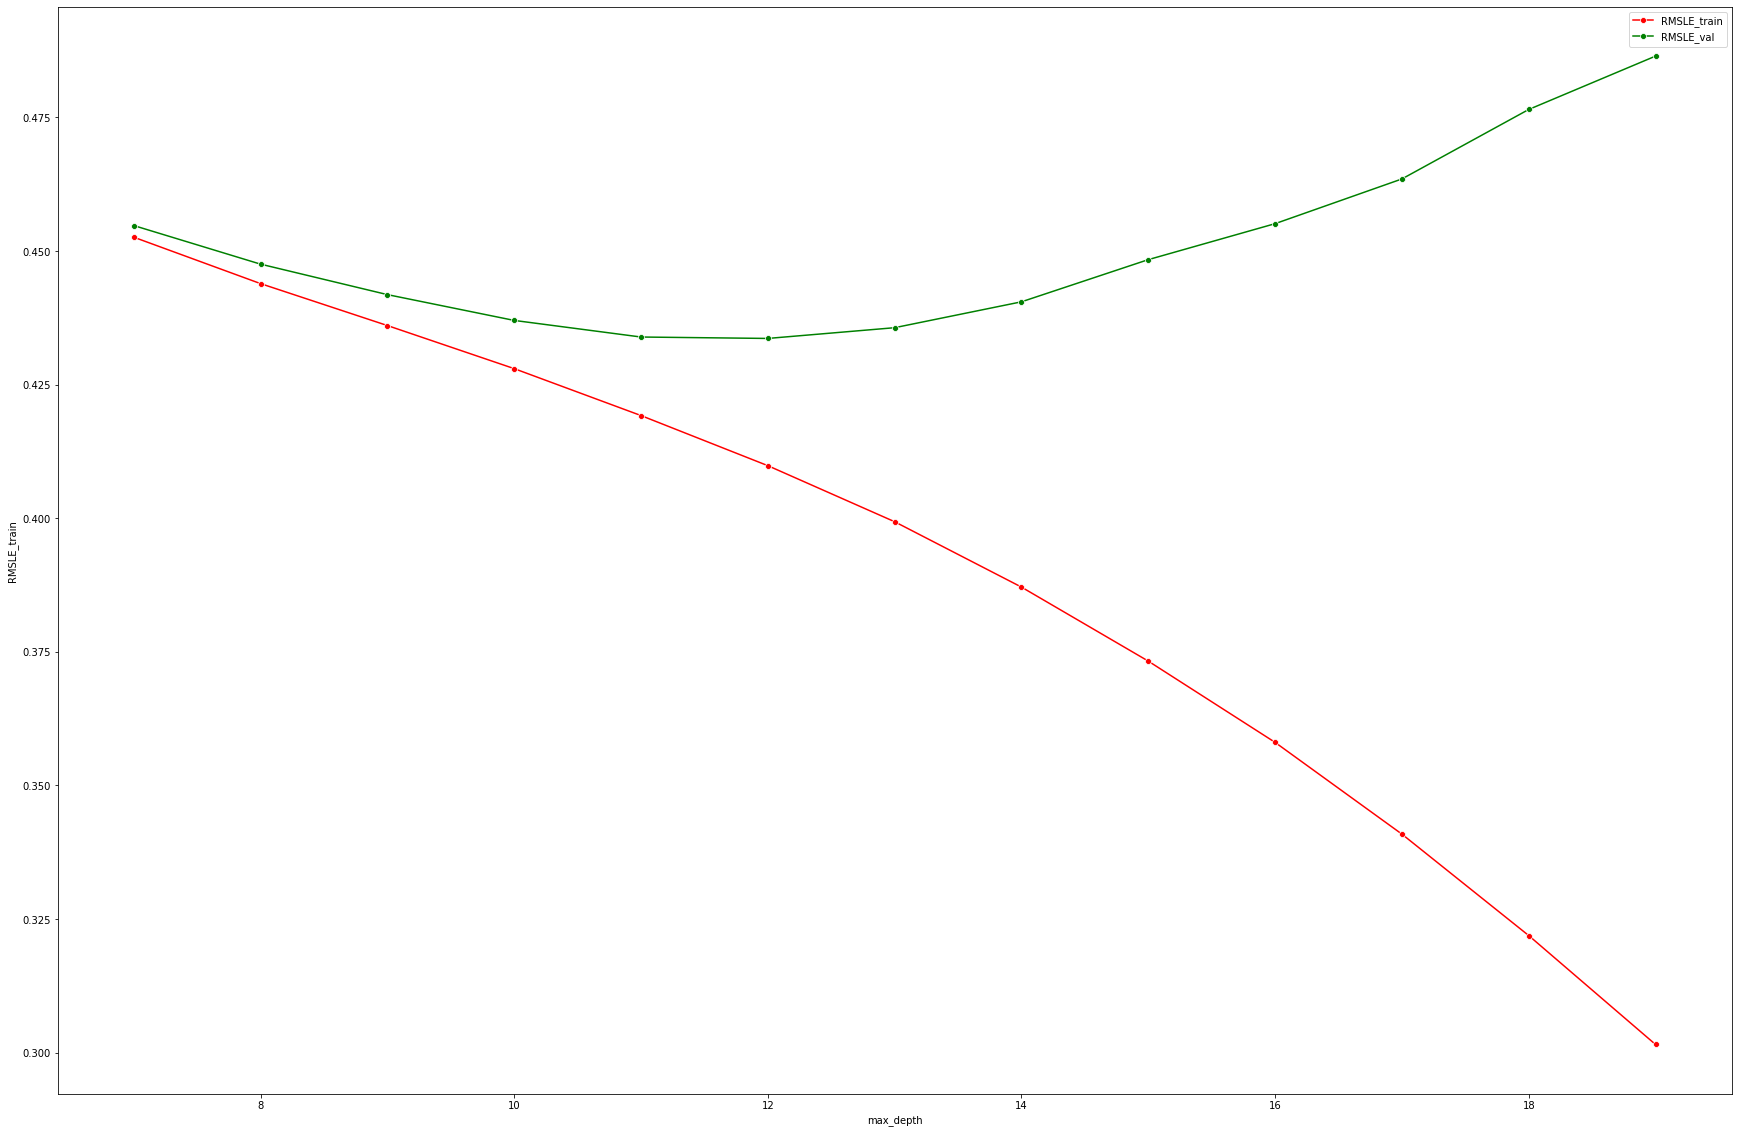

In [59]:
sns.lineplot(x = 'max_depth', y = 'RMSLE_train', data=RMSLE_by_max_depth, color='r', marker='o')
sns.lineplot(x = 'max_depth', y = 'RMSLE_val', data=RMSLE_by_max_depth, color='g', marker='o')

plt.legend(labels=['RMSLE_train','RMSLE_val']);

* In case when max_depth equals 12 the value of RMSLE_val is less than previous and further values.

In [60]:
# DecisionTreeRegressor
dt_rg = tree.DecisionTreeRegressor(
    max_depth=12,
    random_state=RANDOM_SEED
)

# Training Decision Tree by CART algorithm
dt_rg.fit(X_train_scaled, y_train_log)

# Get prediction
y_train_dt = dt_rg.predict(X_train_scaled)
y_valid_dt = dt_rg.predict(X_val_scaled)

# RMSLE computing
print('RMSLE score for train data: {:.3f}'.format(np.sqrt(metrics.mean_squared_error(y_train_log, y_train_dt))))
print('RMSLE score for valid data : {:.3f}'.format(np.sqrt(metrics.mean_squared_error(y_valid_log, y_valid_dt))))

RMSLE score for train data: 0.410
RMSLE score for valid data : 0.434


***

# <p style="text-align:center;font-size:100%;">6. Decision of regression task: Ensembles. Model predictions </p>

In [61]:
regr_rf = ensemble.RandomForestRegressor(n_estimators = 200,
                                         max_depth = 12,
                                         criterion = 'squared_error',
                                         min_samples_split = 20,
                                         random_state = RANDOM_SEED,
                                         verbose=True
                                         )

# Training
regr_rf.fit(X_train_scaled, y_train_log)

# Get prediction
y_train_rf = regr_rf.predict(X_train_scaled)
y_valid_rf = regr_rf.predict(X_val_scaled)

# RMSLE computing
print('RMSLE score for train data: {:.3f}'.format(np.sqrt(metrics.mean_squared_error(y_train_log, y_train_rf))))
print('RMSLE score for valid data : {:.3f}'.format(np.sqrt(metrics.mean_squared_error(y_valid_log, y_valid_rf))))

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed: 27.5min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:   23.6s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


RMSLE score for train data: 0.401
RMSLE score for valid data : 0.416


[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:   11.6s finished


In [62]:
"""
GradientBoostingRegressor model
"""
grad_boost = ensemble.GradientBoostingRegressor(
    learning_rate = 0.5,
    n_estimators = 100, # number of models in ensemble
    max_depth = 6,
    min_samples_split = 30,
    random_state = RANDOM_SEED
    )

# Model training
grad_boost.fit(X_train_scaled, y_train_log)

# Get prediction
y_train_boost = grad_boost.predict(X_train_scaled)
y_valid_boost = grad_boost.predict(X_val_scaled)

# RMSLE computing
print('RMSLE score for train data: {:.3f}'.format(np.sqrt(metrics.mean_squared_error(y_train_log, y_train_boost))))
print('RMSLE score for valid data: {:.3f}'.format(np.sqrt(metrics.mean_squared_error(y_valid_log, y_valid_boost))))

RMSLE score for train data: 0.376
RMSLE score for valid data: 0.397


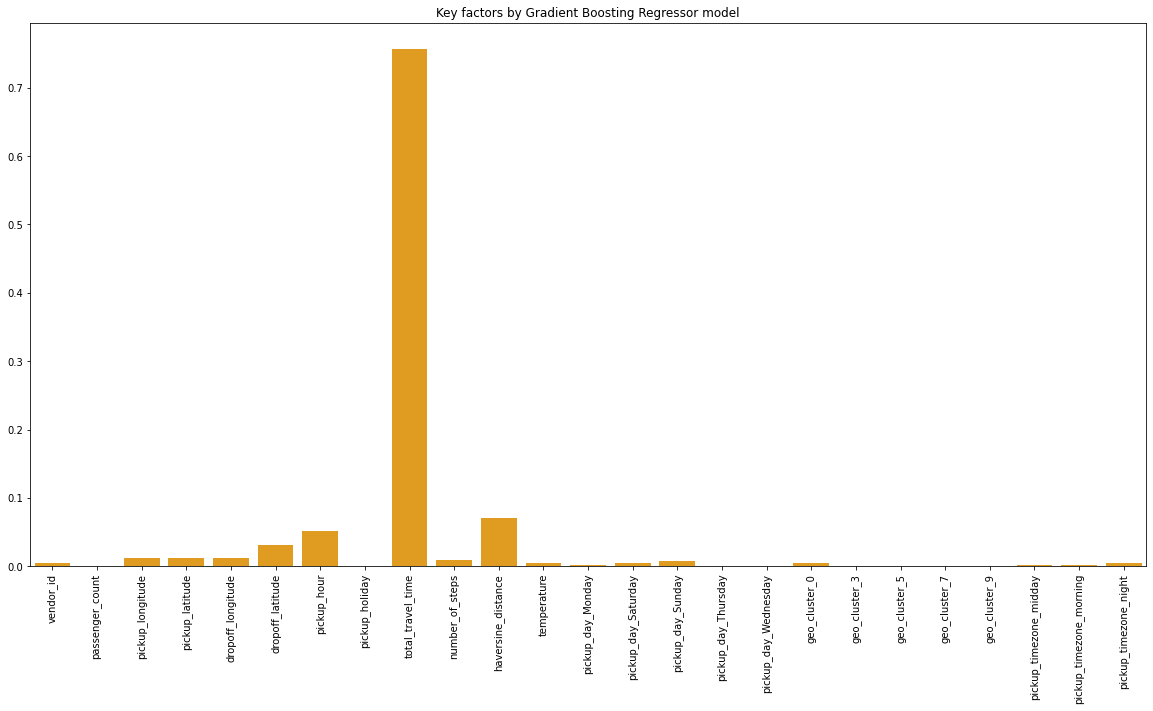

In [63]:
"""
Factors values by GradientBoostingRegressor model
"""
coef = grad_boost.feature_importances_

data_coef = pd.DataFrame([coef], columns=X_train.columns)

fig = plt.figure(figsize=(20, 10))
barplot = sns.barplot(data=data_coef, color='orange')

barplot.set_title('Key factors by Gradient Boosting Regressor model')
barplot.set_xticklabels(barplot.get_xticklabels(), rotation = 90);

Gradient Bossting model's feature importances - **top 3**:

* total_travel_time
* haversine_distance
* pickup_hour

***

RMSLE metric is difficult for interpretation (in case for business task).

We can use median absolute error value for prediction of taxi trip duration.
$$ MeAE = median(|y_i-\hat{y_i}|)$$

In [64]:
# Convert target value from log to norm
y_norm = np.exp(y_valid_log)-1
y_norm_pred = np.exp(y_valid_boost)-1

# Calculate MeAE score
print(f'MeAE score for valid data (in minute) - Gradient Boosting model: {round(metrics.median_absolute_error(y_norm, y_norm_pred) / 60, 2)}')

MeAE score for valid data (in minute) - Gradient Boosting model: 1.87


### `xgboost`

In [65]:
# Создание матриц наблюдений в формате DMatrix
dtrain = xgb.DMatrix(X_train_scaled, label=y_train_log, feature_names=best_features)
dvalid = xgb.DMatrix(X_val_scaled, label=y_valid_log, feature_names=best_features)
# dtest = xgb.DMatrix(X_test_scaled, feature_names=best_features)

# Model's hyperparameters
xgb_pars = {'min_child_weight': 20, 'eta': 0.1, 'colsample_bytree': 0.9, 
            'max_depth': 6, 'subsample': 0.9, 'lambda': 1, 'nthread': -1, 
            'booster' : 'gbtree', 'eval_metric': 'rmse', 'objective': 'reg:squarederror'
           }

# Train and valid sets
watchlist = [(dtrain, 'train'), (dvalid, 'valid')]

# Train XGBoost model
xgb_model = xgb.train(
    params=xgb_pars,
    dtrain=dtrain,
    num_boost_round=300,
    evals=watchlist,
    early_stopping_rounds=20,
    maximize=False,
    verbose_eval=10
)

# Get prediction
y_train_xgb = np.exp(xgb_model.predict(dtrain)) - 1
y_val_xgb = np.exp(xgb_model.predict(dvalid)) - 1

print('Modeling RMSLE %.5f' % xgb_model.best_score)

[0]	train-rmse:5.42232	valid-rmse:5.42203
[10]	train-rmse:1.93631	valid-rmse:1.93624
[20]	train-rmse:0.78622	valid-rmse:0.78705
[30]	train-rmse:0.47970	valid-rmse:0.48170
[40]	train-rmse:0.42215	valid-rmse:0.42483
[50]	train-rmse:0.41015	valid-rmse:0.41322
[60]	train-rmse:0.40582	valid-rmse:0.40934
[70]	train-rmse:0.40243	valid-rmse:0.40629
[80]	train-rmse:0.40027	valid-rmse:0.40451
[90]	train-rmse:0.39866	valid-rmse:0.40321
[100]	train-rmse:0.39672	valid-rmse:0.40154
[110]	train-rmse:0.39521	valid-rmse:0.40034
[120]	train-rmse:0.39477	valid-rmse:0.40003
[130]	train-rmse:0.39392	valid-rmse:0.39940
[140]	train-rmse:0.39279	valid-rmse:0.39865
[150]	train-rmse:0.39166	valid-rmse:0.39782
[160]	train-rmse:0.39096	valid-rmse:0.39734
[170]	train-rmse:0.38971	valid-rmse:0.39645
[180]	train-rmse:0.38907	valid-rmse:0.39614
[190]	train-rmse:0.38839	valid-rmse:0.39579
[200]	train-rmse:0.38746	valid-rmse:0.39512
[210]	train-rmse:0.38658	valid-rmse:0.39462
[220]	train-rmse:0.38609	valid-rmse:0.39446

<AxesSubplot: title={'center': 'Feature importance'}, xlabel='F score', ylabel='Features'>

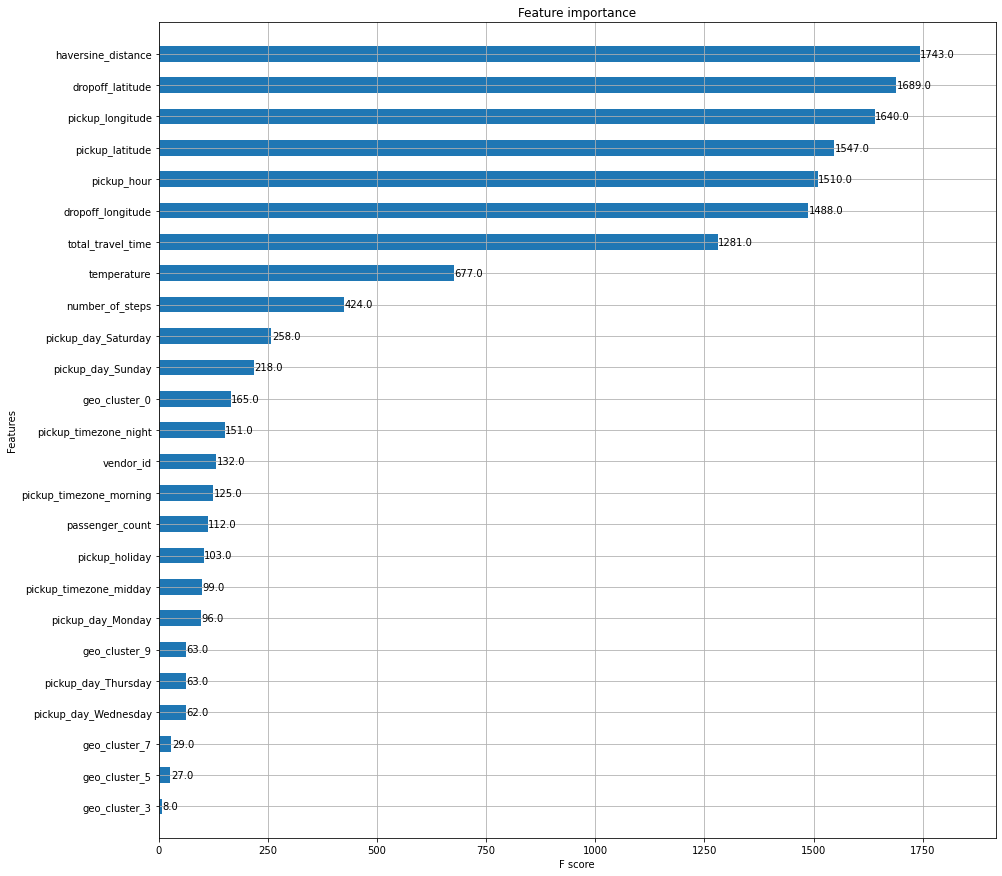

In [66]:
"""
Plot model’s feature importances
"""
fig, ax = plt.subplots(figsize = (15,15))
xgb.plot_importance(xgb_model, ax = ax, height=0.5)

XGBoost model's feature importances - **top 3**:

* haversine_distance
* dropoff_latitude
* pickup_longitude

In [67]:
# Convert target value from log to norm
y_norm = np.exp(y_valid_log)-1

# Calculate MeAE score
print(f'MeAE score for valid data (in minute) - XGBoost model: {round(metrics.median_absolute_error(y_norm, y_val_xgb) / 60, 2)}')

MeAE score for valid data (in minute) - XGBoost model: 1.86


In [68]:
result = pd.DataFrame({
    'Model Name': ['Linear Regression (base)', 'Linear Regression with Polynomial features',
                   'Linear Regression + Poly + L2', 'Decision Tree (by defualt)',
                   'Decision Tree (optimization by GridSearch)', 'Random Forest Regressor',
                   'Gradient Boosting', 'XGBoost'],
    'Hyperparameters': ['', '', 'L2-regularisation', '', 'max_depth=12',
                        'max_depth=12, min_samples_split=20, n_estimators=200, criterion="squared_error"',
                        'learning_rate=0.5, n_estimators=100, max_depth=6, min_samples_split=30',
                        ''],
    'RMSLE, train': ['0.53', '0.45', '0.46', '0.00', '0.41', '0.40', '0.38', '0.38'],
    'RMSLE, valid': ['0.53', '0.53', '0.47', '0.57', '0.43', '0.42', '0.40', '0.39']
})

display(result)

,Model Name,Hyperparameters,"RMSLE, train","RMSLE, valid"
0,Linear Regression (base),,0.53,0.53
1,Linear Regression with Polynomial features,,0.45,0.53
2,Linear Regression + Poly + L2,L2-regularisation,0.46,0.47
3,Decision Tree (by defualt),,0.00,0.57
4,Decision Tree (optimization by GridSearch),max_depth=12,0.41,0.43
5,Random Forest Regressor,"max_depth=12, min_samples_split=20, n_estimato...",0.40,0.42
6,Gradient Boosting,"learning_rate=0.5, n_estimators=100, max_depth...",0.38,0.40
7,XGBoost,,0.38,0.39


***

*Submittion for test data*

In [69]:
test_id = test_data['id']

test_data.head()

,id,vendor_id,pickup_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag
0,id3004672,1,2016-06-30 23:59:58,1,-73.988129,40.732029,-73.990173,40.756680,N
1,id3505355,1,2016-06-30 23:59:53,1,-73.964203,40.679993,-73.959808,40.655403,N
2,id1217141,1,2016-06-30 23:59:47,1,-73.997437,40.737583,-73.986160,40.729523,N
3,id2150126,2,2016-06-30 23:59:41,1,-73.956070,40.771900,-73.986427,40.730469,N
4,id1598245,1,2016-06-30 23:59:33,1,-73.970215,40.761475,-73.961510,40.755890,N


In [70]:
# Convert 'pickup_datetime' column to datetime type
test_data['pickup_datetime'] = pd.to_datetime(test_data['pickup_datetime'], format='%Y-%m-%d %H:%M:%S')

# Getting new features
test_data = add_datetime_features(test_data)
test_data = add_holiday_features(test_data, holiday_data)
test_data = add_osrm_features(test_data, osrm_test)
test_data = add_geographical_features(test_data)
test_data = add_cluster_features(test_data, kmeans_geo)
test_data = add_weather_features(test_data, weather_data)
test_data['pickup_timezone'] = test_data['pickup_datetime'].apply(lambda x: \
    timezone(datetime.datetime.strptime(str(x), '%Y-%m-%d %H:%M:%S').time()))

# Filling missing values
test_data = fill_null_weather_data(test_data)

# Encoding categorical variables
test_data['vendor_id'] = test_data['vendor_id'].apply(lambda x: 0 if x == 1 else 1)
test_data['store_and_fwd_flag'] = test_data['store_and_fwd_flag'].apply(lambda x: 0 if x == 'N' else 1)
test_data = pd.get_dummies(test_data, columns=['pickup_day', 'geo_cluster', 'events', 'pickup_timezone'])

test_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 625134 entries, 0 to 625133
Data columns (total 45 columns):
 #   Column                   Non-Null Count   Dtype         
---  ------                   --------------   -----         
 0   id                       625134 non-null  object        
 1   vendor_id                625134 non-null  int64         
 2   pickup_datetime          625134 non-null  datetime64[ns]
 3   passenger_count          625134 non-null  int64         
 4   pickup_longitude         625134 non-null  float64       
 5   pickup_latitude          625134 non-null  float64       
 6   dropoff_longitude        625134 non-null  float64       
 7   dropoff_latitude         625134 non-null  float64       
 8   store_and_fwd_flag       625134 non-null  int64         
 9   pickup_date              625134 non-null  object        
 10  pickup_hour              625134 non-null  int64         
 11  pickup_holiday           625134 non-null  int64         
 12  total_distance  

In [71]:
# Get X_test matrix
X_test = test_data[best_features]

# Data Normalization
X_test_scaled = mm_scaler.transform(X_test)

print('Shape of data: {}'.format(X_test.shape))

Shape of data: (625134, 25)


In [72]:
dtest = xgb.DMatrix(X_test_scaled, feature_names=best_features)

# Get prediction
y_test_predict = np.exp(xgb_model.predict(dtest)) - 1

In [73]:
submission = pd.DataFrame({'id': test_id, 'trip_duration': y_test_predict})

submission.to_csv('data/submission_xgb.csv', index=False)